<a href="https://colab.research.google.com/github/jordantcarlisle/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
import numpy as np

In [0]:
np.random.randint(0, 10, size=10)

array([5, 1, 1, 6, 3, 8, 3, 5, 4, 6])

In [0]:
import matplotlib.pyplot as plt

In [0]:
x = [10, 20, 35, 48]
y = [25, 45, 31, 10]
print(x ,y)

[10, 20, 35, 48] [25, 45, 31, 10]


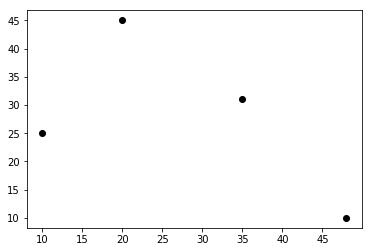

In [0]:
plt.scatter(x, y, color='k')

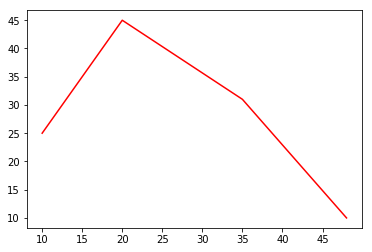

In [0]:
plt.plot(x, y, color='r')

In [0]:
import pandas as pd

In [0]:
df = pd.DataFrame({'hi': x, "bye": y})
df

,hi,bye
0,10,25
1,20,45
2,35,31
3,48,10


In [0]:
df['hi']

0    10
1    20
2    35
3    48
Name: hi, dtype: int64

In [0]:
df.shape

(4, 2)

In [0]:
df['hello'] = df['hi'] + 2*df['bye']

In [0]:
df

,hi,bye,hello
0,10,25,60
1,20,45,110
2,35,31,97
3,48,10,68


In [0]:
df.shape

(4, 3)

In [0]:
arr_1 = np.random.randint(low=0, high=100, size=100000)
arr_2 = np.random.randint(low=0, high=100, size=100000)

In [0]:
arr_1.shape

(100000,)

In [0]:
arr_2.shape

(100000,)

In [0]:
arr_1 + arr_2

array([ 90, 122, 152, ...,  95, 119,  96])

In [0]:
x + y

[10, 20, 35, 48, 25, 45, 31, 10]

In [0]:
type(arr_1)

numpy.ndarray

In [0]:
type(x)

list

In [0]:
df

,hi,bye,hello
0,10,25,60
1,20,45,110
2,35,31,97
3,48,10,68


In [0]:
df['ni hao'] = df['hello'] > 10

In [0]:
df['hello'] > 10

0    True
1    True
2    True
3    True
Name: hello, dtype: bool

In [0]:
df

,hi,bye,hello,ni hao
0,10,25,60,True
1,20,45,110,True
2,35,31,97,True
3,48,10,68,True


In [0]:
df[df['bye'] > 10]

,hi,bye,hello,ni hao
0,10,25,60,True
1,20,45,110,True
2,35,31,97,True


## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

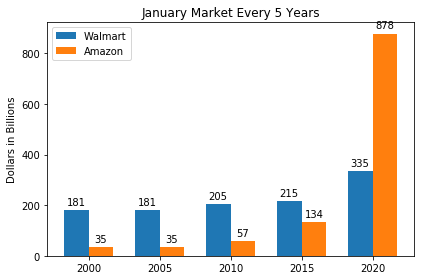

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

import matplotlib.pyplot as plt
import numpy as np


labels = ['2000', '2005', '2010', '2015', '2020']
wmt_mktcap = [181, 181, 205, 215, 335]
amzn_mktcap = [35, 35, 57, 134, 878]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, wmt_mktcap, width, label='Walmart')
rects2 = ax.bar(x + width/2, amzn_mktcap, width, label='Amazon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Dollars in Billions')
ax.set_title('January Market Every 5 Years')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

**A. In the figure above, I charted the total market capitalizatoin of Walmart (seen in blue) compared to Amazon (seen in orange) from 2000 to a 2020 projection. Total market capitalizatoin represents the total market value of a company, and therefore is a good way to compare as a indicator of growth. As you can see in the chart Walmart was significatnly larger than Amazon for nearly two decades. However, despite the fastest growth Walmart has ever seen happening between 2015 and today, Amazon is now valued nearly 3 times that of Walmart.**

2.  What was the most challenging part of what you did?

**A. The most challenging part of what I did was understanding the keywords associated with matplotlib. In fact, I'm still not totally sure of how to use all the key terms and parameters.**

**Other than that, the most difficult thing was collecting data from a historical chart with very poor user experience. It made me excited about how to import data like that into a notebook**

3.  What was the most interesting thing you learned?

**A. The most interesting thing I learned was that it's pretty easy to copy code documentation, play around with settings and data, and totallyl customize something for yourself.**

4.  What area would you like to explore with more time?

**I would like to learn more about how to use numpy and matplotlib to ingest large datasets and simplify them using key value pairs and using logic to filter values that meet specific parameters. 



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!

**I shared this on SLACK - https://a16z.com/2019/06/19/history-and-future-of-machine-learning/**

- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.

**Here's my micro-blog of what I learned https://twitter.com/jordantcarlisle/status/1169404048904216576?s=20**